<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-2-Sprint-2-Regression/blob/master/Copy_of_Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [11]:
#copying my code from last night for clean data set

import pandas as pd
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
#dropping ids and mapping quality to an order of numbers
df=df.drop(['Id','MasVnrArea'],axis=1)
qual_dict={'NA':-1,'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
cat_quals=['ExterQual','ExterCond','KitchenQual','BsmtQual','BsmtCond','GarageQual','GarageCond','HeatingQC','FireplaceQu']#,'Fence']
for col in cat_quals:
  df[col]=df[col].map(qual_dict)
#new build category and renovated category using YrSold, 'YearBuilt', 'YearRemodAdd
df['new_build']=np.where((df['YrSold']==df['YearBuilt']),1,0)
df['reno']=np.where((df['YearBuilt']!=df['YearRemodAdd']),1,0)
df['SF_per_room']=(df['1stFlrSF']+df['2ndFlrSF'])/df['TotRmsAbvGrd']
df['bth_per_SF']=(df['BsmtFullBath']+0.5*df['BsmtHalfBath']+ df['FullBath']+0.5*df['HalfBath'])/df['GrLivArea']
df['rel_lot_size']=df['LotArea']/df['GrLivArea'] 
df['fireplace_per_SF']=df['Fireplaces']/df['GrLivArea']
#make a dictionary of urban density and use it to make new column
density_dict=df.groupby('Neighborhood', as_index=False)['LotArea'].mean().set_index('Neighborhood').to_dict()['LotArea']
df['urban_density']=df['Neighborhood'].map(density_dict)
#same for area age
age_dict=df.groupby('Neighborhood', as_index=False)['YearBuilt'].mean().set_index('Neighborhood').to_dict()['YearBuilt']
df['area_age']=df['Neighborhood'].map(age_dict)
#now an area quality dictionary
area_qual_dict=df.groupby('Neighborhood', as_index=False)['OverallQual'].mean().set_index('Neighborhood').to_dict()['OverallQual']
df['area_qual']=df['Neighborhood'].map(area_qual_dict)
#noise polution list and check
noise_high_list=['Artery','RRAn','RRAe']
df['noisy']=np.where(df['Condition1'].isin(noise_high_list),1,0)
df['ln_price'] = np.log(df['SalePrice'])
df_coded=df.copy()
for col in df_coded.columns:
  if df_coded[col].dtype=='O':
    df_coded[col] = pd.Categorical(df_coded[col])
    df_coded[col] = df_coded[col].cat.codes
    
df_coded['LotFrontage']=df_coded['LotFrontage'].fillna(df_coded['LotFrontage'].mean())
df_coded['FireplaceQu']=df_coded['FireplaceQu'].fillna(0)
df_coded['GarageQual']=df_coded['GarageQual'].fillna(0)
df_coded['GarageCond']=df_coded['GarageCond'].fillna(0)
df_coded['BsmtQual']=df_coded['BsmtQual'].fillna(0)
df_coded['BsmtCond']=df_coded['BsmtCond'].fillna(0)
df_coded['GarageYrBlt']=np.where(df_coded['GarageYrBlt'].isna()==True,df_coded['YearBuilt'],df_coded['GarageYrBlt'])
corr_list=[]
for col in df_coded.columns:
  aaa=(col,df_coded['ln_price'].corr(df_coded[col]))
  corr_list.append(aaa)
  
corr_list.sort(key=lambda x: x[1])
lin_feats=[corr_list[-12:-2][i][0] for i in range(0,len(corr_list[-12:-2]))]
additional_features=[corr_list[-22:-12][i][0] for i in range(0,len(corr_list[-22:-12]))]
even_more_feats=[corr_list[-32:-22][i][0] for i in range(0,len(corr_list[-22:-12]))]
poly_feats=[]
for ft in (lin_feats+additional_features+even_more_feats):
  name = f'{ft} **2'
  df_coded[name]=df_coded[ft]**2
  poly_feats.append(name)
ft_list=['SalePrice','ln_price','FullBath', 'YearBuilt', 'Functional', 'ScreenPorch', 'HeatingQC **2', 'SaleCondition', 'OverallCond', 'BldgType', 'GrLivArea **2', 'BsmtCond', '2ndFlrSF', 'BsmtFinSF2', 'CentralAir', 'WoodDeckSF', 'OverallQual', 'FullBath **2', 'BsmtFinSF1', 'LowQualFinSF', '2ndFlrSF **2', 'Fireplaces', 'GarageQual', 'KitchenQual **2', '1stFlrSF', 'bth_per_SF', 'area_qual **2', 'GarageCars **2', 'KitchenQual', 'rel_lot_size']

dff=df_coded[ft_list].copy()
dff.head()

,SalePrice,ln_price,FullBath,YearBuilt,Functional,ScreenPorch,HeatingQC **2,SaleCondition,OverallCond,BldgType,...,2ndFlrSF **2,Fireplaces,GarageQual,KitchenQual **2,1stFlrSF,bth_per_SF,area_qual **2,GarageCars **2,KitchenQual,rel_lot_size
0,208500,12.247694,2,2003,6,0,16,4,5,0,...,729316,0,2.0,9,856,0.002047,44.089600,4,3,4.941520
1,181500,12.109011,2,1976,6,0,16,4,8,0,...,0,1,2.0,4,1262,0.001981,45.256198,4,2,7.606973
2,223500,12.317167,2,2001,6,0,16,4,5,0,...,749956,1,2.0,9,920,0.001960,44.089600,4,3,6.298992
3,140000,11.849398,1,1915,6,0,9,0,5,0,...,571536,1,2.0,9,961,0.001165,39.369473,9,3,5.562027
4,250000,12.429216,2,2000,6,0,16,4,5,0,...,1108809,1,2.0,9,1145,0.001592,62.834622,9,3,6.487716


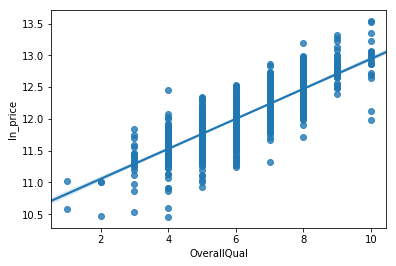

In [12]:
import seaborn as sns
X=dff['OverallQual']
y=dff['SalePrice']
ax = sns.regplot(x='OverallQual', y='ln_price', data=dff)

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [13]:
import statsmodels.api as sm
#takign reduced amount of features
target = 'SalePrice'
features=['GrLivArea **2', '2ndFlrSF', 'YearBuilt', '2ndFlrSF **2', 'area_qual **2', 
          '1stFlrSF', 'OverallQual', 'KitchenQual **2', 'BldgType', 'SaleCondition', 'GarageQual',
          'BsmtCond', 'LowQualFinSF', 'BsmtFinSF1', 'OverallCond']
X = dff[features] 
y = dff[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     524.1
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        19:02:50   Log-Likelihood:                -17184.
No. Observations:                1460   AIC:                         3.440e+04
Df Residuals:                    1444   BIC:                         3.448e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.628e+05   8.59e+04     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [0]:
#ihave some high p values in 2ndFlrSF, GarageQual & BsmtCond.  this means they are less meaningful to the model


## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [14]:
from scipy import stats
print(dff.shape)
dff = dff[(np.abs(stats.zscore(dff)) < 3).all(axis=1)]
print(dff.shape)

(1460, 30)
(990, 30)


In [15]:
X = dff[features] 
y = dff[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     470.0
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        19:03:43   Log-Likelihood:                -11287.
No. Observations:                 990   AIC:                         2.261e+04
Df Residuals:                     974   BIC:                         2.268e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.195e+05   8.67e+04     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
#the pvalues of some of my features are now higher if they were already high, 2ndFlrSF ,2ndFlrSF **2 ,GarageQual,BsmtCond,LowQualFinSF
#all high levels

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [16]:
target = 'ln_price'
features=['GrLivArea **2', '2ndFlrSF', 'YearBuilt', '2ndFlrSF **2', 'area_qual **2', 
          '1stFlrSF', 'OverallQual', 'KitchenQual **2', 'BldgType', 'SaleCondition', 'GarageQual',
          'BsmtCond', 'LowQualFinSF', 'BsmtFinSF1', 'OverallCond']
X = dff[features] 
y = dff[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     541.4
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        19:05:42   Log-Likelihood:                 828.12
No. Observations:                 990   AIC:                            -1624.
Df Residuals:                     974   BIC:                            -1546.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.3561      0.420     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
pd.Series(vif, X.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const              15629.075469
GrLivArea **2         55.543918
2ndFlrSF              40.809299
YearBuilt              3.186159
2ndFlrSF **2          23.684802
area_qual **2          2.915328
1stFlrSF              35.898186
OverallQual            3.270939
KitchenQual **2        2.108633
BldgType               1.212372
SaleCondition          1.217928
GarageQual             1.107560
BsmtCond               1.051338
LowQualFinSF           1.042749
BsmtFinSF1             1.221121
OverallCond            1.532496
dtype: float64

In [0]:
#GrLivArea **2,2ndFlrSF  ,2ndFlrSF **2  ,1stFlrSF all have high colinearity

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [18]:
#you can see that meany of them have corr over 60
X.corr()

,const,GrLivArea **2,2ndFlrSF,YearBuilt,2ndFlrSF **2,area_qual **2,1stFlrSF,OverallQual,KitchenQual **2,BldgType,SaleCondition,GarageQual,BsmtCond,LowQualFinSF,BsmtFinSF1,OverallCond
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GrLivArea **2,NaN,1.000000,0.662103,0.259275,0.731113,0.429050,0.387297,0.542913,0.415322,-0.168184,0.094933,0.087923,0.027961,0.006652,0.062832,-0.184270
2ndFlrSF,NaN,0.662103,1.000000,0.059435,0.960415,0.152773,-0.417607,0.205999,0.108683,-0.099090,-0.025400,0.016467,-0.013237,0.045561,-0.230060,-0.067506
YearBuilt,NaN,0.259275,0.059435,1.000000,0.134312,0.697070,0.268458,0.622547,0.532169,0.226049,0.319707,0.240870,0.170558,-0.080824,0.141596,-0.532583
2ndFlrSF **2,NaN,0.731113,0.960415,0.134312,1.000000,0.216938,-0.311837,0.251287,0.163828,-0.120476,-0.007730,0.024472,0.010193,0.019645,-0.172378,-0.098411
area_qual **2,NaN,0.429050,0.152773,0.697070,0.216938,1.000000,0.348832,0.723276,0.609485,0.206366,0.320434,0.121194,0.108420,-0.007333,0.102700,-0.358934
1stFlrSF,NaN,0.387297,-0.417607,0.268458,-0.311837,0.348832,1.000000,0.441560,0.387121,-0.076853,0.160767,0.094028,0.051355,-0.061652,0.343105,-0.170097
OverallQual,NaN,0.542913,0.205999,0.622547,0.251287,0.723276,0.441560,1.000000,0.674642,0.081446,0.290158,0.151330,0.101380,-0.024093,0.096155,-0.289144
KitchenQual **2,NaN,0.415322,0.108683,0.532169,0.163828,0.609485,0.387121,0.674642,1.000000,0.060896,0.310160,0.070489,0.088228,-0.020131,0.122854,-0.175888
BldgType,NaN,-0.168184,-0.099090,0.226049,-0.120476,0.206366,-0.076853,0.081446,0.060896,1.000000,0.013760,0.054444,0.044721,0.039381,0.009320,-0.200156


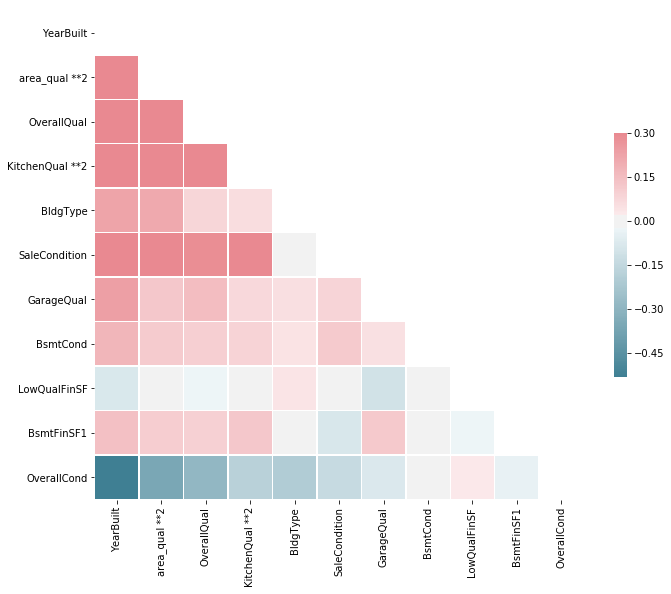

In [23]:
import matplotlib.pyplot as plt
corr=X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,                         #
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [19]:
target = 'ln_price'
new_feats=['YearBuilt', 'area_qual **2', 
          'OverallQual', 'KitchenQual **2', 'BldgType', 'SaleCondition', 'GarageQual',
          'BsmtCond', 'LowQualFinSF', 'BsmtFinSF1', 'OverallCond']
X = dff[new_feats] 
y = dff[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     338.6
Date:                Wed, 01 May 2019   Prob (F-statistic):          4.94e-324
Time:                        19:10:28   Log-Likelihood:                 499.53
No. Observations:                 990   AIC:                            -975.1
Df Residuals:                     978   BIC:                            -916.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.8778      0.557     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [20]:
#my standard errors are all higher a little
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     323.7
Date:                Wed, 01 May 2019   Prob (F-statistic):          9.22e-317
Time:                        19:12:29   Log-Likelihood:                 499.53
No. Observations:                 990   AIC:                            -975.1
Df Residuals:                     978   BIC:                            -916.3
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.8778      0.587     

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

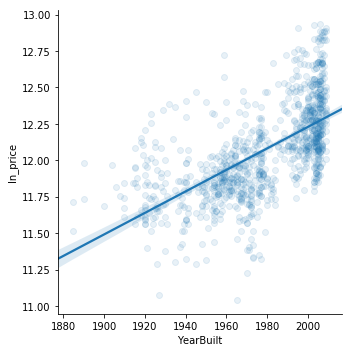

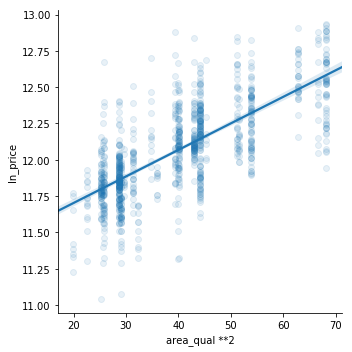

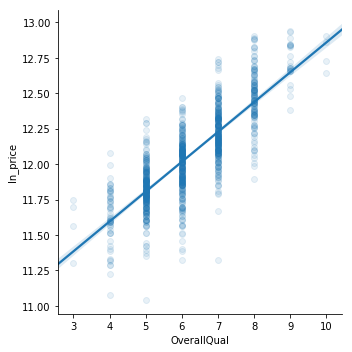

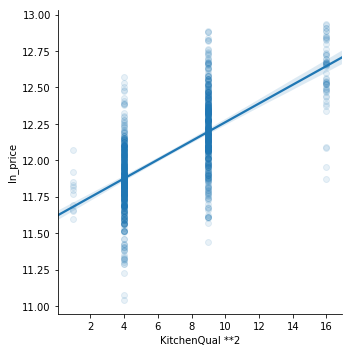

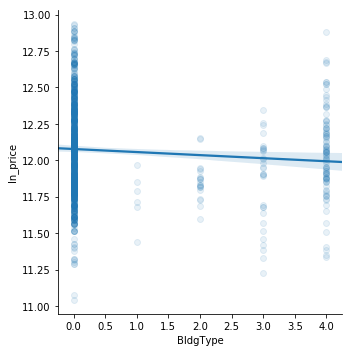

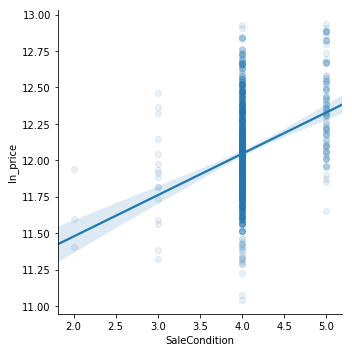

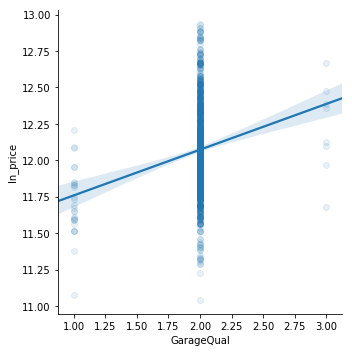

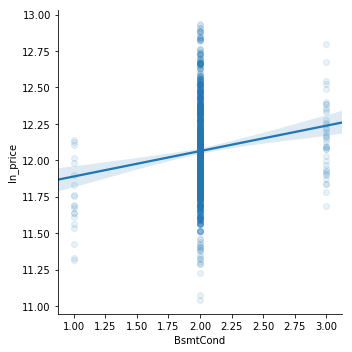

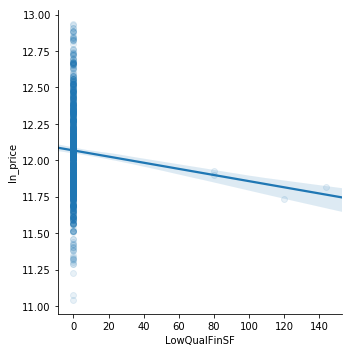

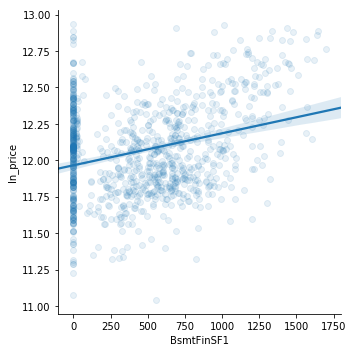

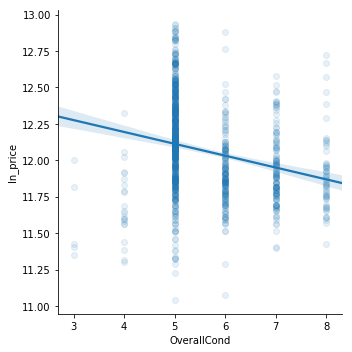

In [26]:
for feat in new_feats:

    sns.lmplot(x=feat, y=target, data=dff, scatter_kws=dict(alpha=0.1))
    plt.show()

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

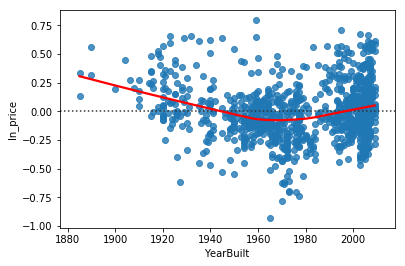

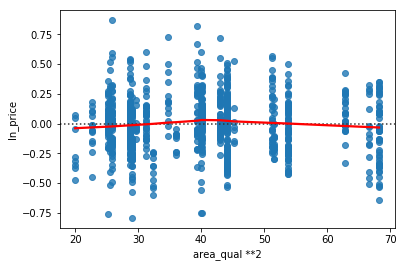

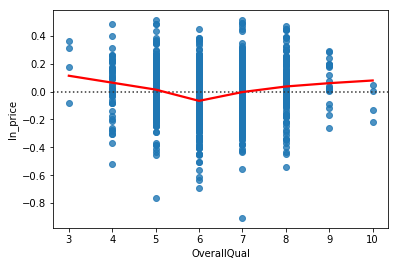

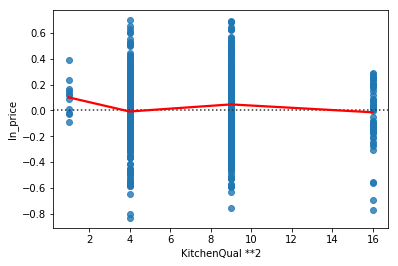

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


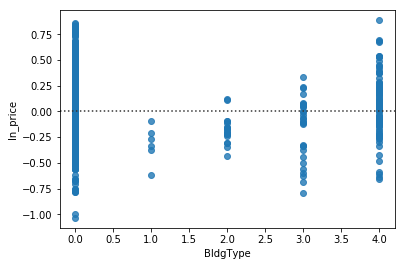

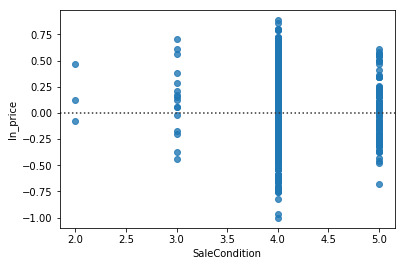

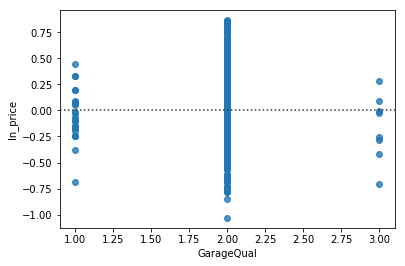

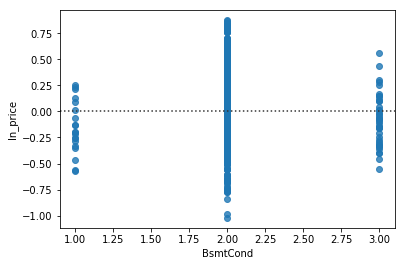

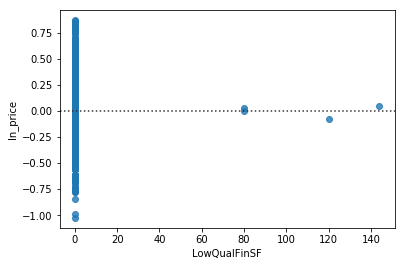

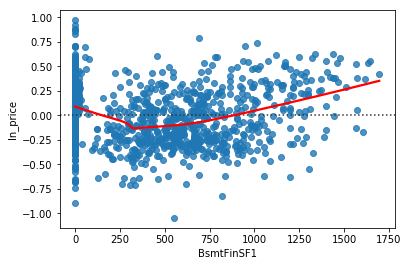

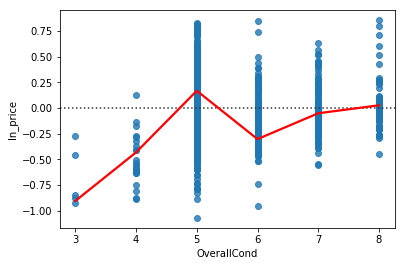

In [25]:
for feat in new_feats:
    sns.residplot(X[feat], y, lowess=True, line_kws=dict(color='r'))
    plt.show()

In [0]:
#looks like year built and basementSF1 are good candidates for poly features

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [27]:
dff['yrbltsqrd']=dff['YearBuilt']**2
dff['BFinSF1sqrd']=dff['BsmtFinSF1']**2

new_new_feats=['YearBuilt', 'area_qual **2', 
          'OverallQual', 'KitchenQual **2', 'BldgType', 'SaleCondition', 'GarageQual',
          'BsmtCond', 'LowQualFinSF', 'BsmtFinSF1', 'OverallCond','yrbltsqrd','BFinSF1sqrd']

X = dff[new_new_feats] 
y = dff[target]
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     290.6
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        19:26:28   Log-Likelihood:                 505.90
No. Observations:                 990   AIC:                            -983.8
Df Residuals:                     976   BIC:                            -915.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              45.6444     28.771     

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
#not really.  it's hard to tell which variables are going to be mroe independent from teh rest of theem, though i guess a few i removed
#were clearly colinear.  my standard error is super small now soi guess that is a big positive, however i still haev one high p value

# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other diagnostic tests. Can you show that residuals are normally distributed graphically?
- Write a blog post about inferential modeling using linear regression.